# SegNet with PyTorch
**References**  
1. https://arxiv.org/abs/1511.00561
2. http://blog.qure.ai/notes/semantic-segmentation-deep-learning-review
3. https://arxiv.org/abs/1409.1556

**Summary:**  

This core trainable segmentation engine consists of an encoder network, a corresponding decoder network followed by a pixel-wise classification layer. The architecture of the encoder network is topologically identical to the 13 convolutional layers in the VGG16 network 

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pylab
from random import randint, choice, seed
from cv2 import resize, imread, imwrite, cvtColor, INTER_NEAREST, INTER_CUBIC, IMREAD_COLOR, COLOR_BGR2RGB

# COCO dataset API
from pycocotools.coco import COCO

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# interactive mode
plt.ion()   

# Image augmentation
import imgaug as ia
from imgaug import augmenters as iaa

# # set seed
# torch.manual_seed(1)

# define data set location
dataDir='/home/jeff/Documents/data_sets/coco' # modify this path appropriatly to your downloaded coco dataset
dataType=['train2017','val2017']
train_annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType[0])
test_annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType[1])

# initialize COCO api for instance annotations
coco_train=COCO(train_annFile)
coco_test=COCO(test_annFile)

loading annotations into memory...
Done (t=13.92s)
creating index...
index created!
loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


In [2]:
class COCO_dataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, data_split, object_classes, coco_API, im_width, im_height, data_dir, cache_dir, transform = None, augment = None):
        'Initialization'
        self.list_IDs = list_IDs
        self.data_split = data_split
        self.data_dir = data_dir
        self.coco_API = coco_API
        self.cache_dir = cache_dir
        
        self.im_width = im_width
        self.im_height = im_height
        
        # make dictionary of object_classes
        self.objects_dict = dict()
        for i,obj in enumerate(object_classes):
            self.objects_dict.update({obj:i+1})

        # get coco category IDs
        self.COCO_id_dict = dict()
        for obj in object_classes:
            obj_id = coco_train.getCatIds(catNms=obj);
            self.COCO_id_dict.update({obj_id[0]:obj})
        
        # define augmentations
        self.augment = augment
        
        # define transformations
        self.transform = transform
            
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        ID = int(ID)
        
        # read image from cache and check to see if it exists.
        X = imread(os.path.join(self.cache_dir, self.data_split, str(ID) + '.jpg'), IMREAD_COLOR)
        
        try:
            # if X is an array: the image is in the cache, and we will pass over the except statement
            X.any()

        except AttributeError:
            # If X is not an array: the image is not in the cache.
            # we will load and save the image and mask into the cache            
                
            # Load data and get label
            img = self.coco_API.loadImgs([ID])[0]
            X = imread(os.path.join(self.data_dir, 'images', self.data_split, img['file_name']), IMREAD_COLOR)
            X = cvtColor(X, COLOR_BGR2RGB)

            # generate the GT mask image
            h,w,c = X.shape
            y = np.zeros((h,w))

            # load GT of requested image with only the desired objects labeled
            annIds = self.coco_API.getAnnIds(imgIds=[ID], catIds=self.COCO_id_dict.keys(), iscrowd=False)
            annotations = self.coco_API.loadAnns(annIds)

            # replace COCO label with objects_dict label
            for ann in annotations:
                object_name = self.COCO_id_dict[ann['category_id']]
                objet_label = self.objects_dict[object_name]
                gt = self.coco_API.annToMask(ann)
                y[gt == 1] = objet_label

            imwrite(os.path.join(self.cache_dir, self.data_split, str(ID) + '.jpg'), X)
            imwrite(os.path.join(self.cache_dir, self.data_split, str(ID) + '.png'), y)
            
            # crop images to same size
            X,y = COCO_dataset.Random_Sized_Crop(X, y, self.im_width, self.im_height, static = True)
            
            # add dimenstion to mask as H * W * C
            y = y[...,np.newaxis]

            # apply requested augmentations
            if self.augment:
                random_integer = randint(1,1001)
                X,y = self.augment(X, y, random_integer)

            # convert images to C * H * W
            X = X.transpose((2, 0, 1))
            y = y.transpose((2, 0, 1))
                
            # package into dictionary  
            sample = {'image':X.astype(np.float), 'mask':y.astype(np.float)}

            # apply requested transformations
            if self.transform:
                sample = self.transform(sample)

            return sample
        
        # read images if cache is not empty
        y = imread(os.path.join(self.cache_dir, self.data_split, str(ID) + '.png'))

        y = y[:,:,0]
        
        # crop images to same size
        X,y = COCO_dataset.Random_Sized_Crop(X, y, self.im_width, self.im_height, static = False)

        # add dimenstion to mask as H * W * C
        y = y[...,np.newaxis]

        # apply requested augmentations
        if self.augment:
            random_integer = randint(1,1001)
            X,y = self.augment(X, y, random_integer)

        # convert images to C * H * W
        X = X.transpose((2, 0, 1))
        y = y.transpose((2, 0, 1))
        
        # package into dictionary  
        sample = {'image':X.astype(np.float), 'mask':y.astype(np.float)}

        # apply requested transformations
        if self.transform:
            sample = self.transform(sample)

        return sample
    
    @staticmethod
    def get_classifier_data(object_classes, coco_API):
        '''
        After initialization, the function get_classifier_data is called to generate the dataframe of images that
        contain the classes desired by user
        '''
        # get list of images that contain the desired categories
        data = set()
        for cat in object_classes:
            classId = coco_API.getCatIds(catNms=cat)
            imageIds = coco_API.getImgIds(catIds=classId)
            data.update(imageIds)

        # convert to dataframe and add labels
        data = np.array(list(data), dtype=str)

        return data
    
    @staticmethod
    def find_bad_images(image_list, data_dir, data_split, object_classes, coco_API):
        # find B&W images and Images where mask dims != iamge dims, then remove from training and validation images
        bad_images = []
        for im_Number in image_list:
            # get image number
            im_Number = int(im_Number)

            # read the original image
            img = coco_API.loadImgs(im_Number)[0]
            data_arr = imread(os.path.join(data_dir, 'images', data_split, img['file_name']), IMREAD_COLOR)
            data_arr = cvtColor(data_arr, COLOR_BGR2RGB)

            # read instance annotation
            gt = np.zeros((data_arr.shape[0],data_arr.shape[1]))
            mask = []
            for cat in object_classes:
                catIds = coco_API.getCatIds(catNms=cat);
                annIds = coco_API.getAnnIds(imgIds=[im_Number], catIds=catIds, iscrowd=False)
                anns = coco_API.loadAnns(annIds)
                for ann in anns:
                    mask = coco_API.annToMask(ann)
                    gt[mask == 1] = 1

            # some images have no postivie targets
            if isinstance(mask, list):
#                 print 'bad mask {}'.format(im_Number)
                bad_images.append(str(im_Number))

            # check that the image and mask have the same dimensions
            elif (mask.shape[:2] != data_arr.shape[:2]):
#                 print 'mask shape != image shape {}'.format(im_Number)            
                bad_images.append(str(im_Number))

            # some B&W images have onle 1 channel            
            elif len(data_arr.shape) != 3:
#                 print 'black and white image {}'.format(im_Number)
                bad_images.append(str(im_Number))

            # some B&W images have 3 channels, but they are all equivalent
            elif np.array_equal(data_arr[:,:,0],data_arr[:,:,1]):
#                 print 'black and white image {}'.format(im_Number)
                bad_images.append(str(im_Number))

            else:
                continue

        return bad_images
    
    @staticmethod
    def Random_Sized_Crop(img, mask, width=224, height=224, static = False):
        # define random crop transformation for image augmentation
        # Images in cv2 are defined as columns by rows [width x height]

        if static:
            seed(777)

        assert img.shape[0] == mask.shape[0]
        assert img.shape[1] == mask.shape[1]

        if img.shape[1] < width:
            img = resize(img, (width, img.shape[0]), interpolation = INTER_CUBIC)
            mask = resize(mask, (width, mask.shape[0]), interpolation = INTER_NEAREST)   

        if img.shape[0] < height:
            img = resize(img, (img.shape[1], height), interpolation = INTER_CUBIC)
            mask = resize(mask, (mask.shape[1], height), interpolation = INTER_NEAREST)        

        x = randint(0, img.shape[1] - width)
        y = randint(0, img.shape[0] - height)

        img = img[y:y+height, x:x+width]
        mask = mask[y:y+height, x:x+width]

        return img, mask

## 1.0 Begin with developing the encoder, a 13 layer VGG16 network for 2-class classification

Dataset: COCO

## Architecture
### Encoder
SegNet  has  an  encoder  network  and  a  corresponding  decoder network,  followed  by  a  final  pixelwise  classification  layer.  

The encoder network consists of 13 convolutional  layers  which  correspond  to  the  first 13 convolutional layers in the VGG16 network 

Each encoder in  the  encoder  network  performs  convolution with  a  filter  bank  to  produce  a  set  of  feature  maps.  These  are then batch normalized.

Then an element-wise rectified-linear non-linearity (ReLU) max(0, x) is applied. 

Following that, max-pooling with a 2 × 2 window and stride 2 (non-overlapping window) is performed and the resulting output is sub-sampled by a factor of 2.

### Decoder
SegNet uses the max pooling indices to upsample (without learning) the feature map(s) and convolves with a trainable decoder filter bank. The max-pooling indices, i.e,  the  locations  of  the  maximum  feature  value  in  each  pooling window, are stored for each encoder feature map.

The  appropriate decoder in  the  decoder  network  upsamples its input feature map(s) using the memorized max-pooling indices from  the  corresponding  encoder  feature  map(s). This  step  produces  sparse  feature  map(s).

These feature maps are then convolved with a  trainable  decoder  filter  bank  to  produce  dense  feature  maps.

A batch normalization step is then applied to each of these maps.

The high dimensional feature representation at the output of the final decoder  is  fed  to  a  trainable  soft-max  classifier.  This  soft-max classifies  each  pixel  independently.  The  output  of  the  soft-max classifier  is  a  K  channel  image  of  probabilities  where  K  is  the number of classes. The predicted segmentation corresponds to the class with maximum probability at each pixel.

## Layer Summary  
### (note: zero padding is used during convolution steps)
n-chanels = 3  
len(x) = 224  
len(y) = 224

Input Image 3 x 224 x 224  

## Encoder
1. conv. 64 kernels with size: n-chanels x 3 x 3 + ReLU
2. conv. 64 kernels with size: 64 x 3 x 3 + ReLU
3. MaxPool 2 × 2 pixel window, with stride 2, return_indices = True (feature map size = 64 X 112 X 112)
4. BatchNorm
5. conv. 128 kernels with size: 64 x 3 x 3 + ReLU
6. conv. 128 kernels with size: 128 x 3 x 3 + ReLU
7. MaxPool 2 × 2 pixel window, with stride 2, return_indices = True (feature map size = 128 X 56 X 56)
8. BatchNorm2d
9. conv. 256 kernels with size: 128 x 3 x 3 + ReLU
10. conv. 256 kernels with size: 256 x 3 x 3 + ReLU
11. MaxPool 2 × 2 pixel window, with stride 2, return_indices = True (feature map size = 256 X 28 X 28)
12. BatchNorm2d
13. conv. 512 kernels with size: 256 x 3 x 3 + ReLU
14. conv. 512 kernels with size: 512 x 3 x 3 + ReLU
15. MaxPool 2 × 2 pixel window, with stride 2, return_indices = True (feature map size = 512 X 14 X 14)
16. BatchNorm2d
17. conv. 512 kernels with size: 512 x 3 x 3 + ReLU
18. conv. 512 kernels with size: 512 x 3 x 3 + ReLU
19. MaxPool 2 × 2 pixel window, with stride 2, return_indices = True (feature map size = 512 X 7 X 7)
20. BatchNorm2d


## Decoder
1. Upsample: Pooling indices to pad prior feature map (feature map size = 512 X 7 X 7)
2. conv. 512 kernels with size: 512 x 3 x 3 + ReLU
3. conv. 512 kernels with size: 512 x 3 x 3 + ReLU
4. BatchNorm2d
5. Upsample: Pooling indices to pad prior feature map (feature map size = 512 X 14 X 14)
6. conv. 512 kernels with size: 256 x 3 x 3 + ReLU
7. conv. 256 kernels with size: 256 x 3 x 3 + ReLU
8. BatchNorm2d
9. Upsample: Pooling indices to pad prior feature map (feature map size = 256 X 28 X 28)
10. conv. 256 kernels with size: 128 x 3 x 3 + ReLU
11. conv. 128 kernels with size: 128 x 3 x 3 + ReLU
12. BatchNorm2d
13. Upsample: Pooling indices to pad prior feature map (feature map size = 128 X 56 X 56)
14. conv. 128 kernels with size: 64 x 3 x 3 + ReLU
15. conv. 64 kernels with size: 64 x 3 x 3 + ReLU
16. BatchNorm2d
17. Upsample: Pooling indices to pad prior feature map (feature map size = 64 X 112 X 112)
18. conv. 128 kernels with size: 64 x 3 x 3 + ReLU
19. conv. 64 kernels with size: 64 x 3 x 3 + ReLU
20. BatchNorm2d
21. Upsample: Pooling indices to pad prior feature map (feature map size = 64 X 224 X 224)
22. Softmax

(NOTE: this information does not account for shrinking of images from unpadded convolutions)

In [3]:
class SegNet(nn.Module):
    '''
    This is an implementation of SegNet based on the paper "SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation"
    
    CHECK OUT: https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py for brilliant way to vary
                the netwrok layers
    
    Layer Summary

    n-chanels = 3  
    len(x) = 224  
    len(y) = 224

    Input Image 3 x 224 x 224  

    ## Encoder
    This is an implementation of the 13 layer ConvNet Configuration from VERY DEEP CONVOLUTIONAL NETWORKS
    FOR LARGE-SCALE IMAGE RECOGNITION
    
    1. conv. 64 kernels with size: n-chanels x 3 x 3 + ReLU
    2. conv. 64 kernels with size: 64 x 3 x 3 + ReLU
    3. MaxPool 2 × 2 pixel window, with stride 2, return_indices = True (feature map size = 64 X 112 X 112)
    4. BatchNorm
    5. conv. 128 kernels with size: 64 x 3 x 3 + ReLU
    6. conv. 128 kernels with size: 128 x 3 x 3 + ReLU
    7. MaxPool 2 × 2 pixel window, with stride 2, return_indices = True (feature map size = 128 X 56 X 56)
    8. BatchNorm2d
    9. conv. 256 kernels with size: 128 x 3 x 3 + ReLU
    10. conv. 256 kernels with size: 256 x 3 x 3 + ReLU
    11. MaxPool 2 × 2 pixel window, with stride 2, return_indices = True (feature map size = 256 X 28 X 28)
    12. BatchNorm2d
    13. conv. 512 kernels with size: 256 x 3 x 3 + ReLU
    14. conv. 512 kernels with size: 512 x 3 x 3 + ReLU
    15. MaxPool 2 × 2 pixel window, with stride 2, return_indices = True (feature map size = 512 X 14 X 14)
    16. BatchNorm2d
    17. conv. 512 kernels with size: 512 x 3 x 3 + ReLU
    18. conv. 512 kernels with size: 512 x 3 x 3 + ReLU
    19. MaxPool 2 × 2 pixel window, with stride 2, return_indices = True (feature map size = 512 X 7 X 7)
    20. BatchNorm2d


    ## Decoder
    1. Upsample: Pooling indices to pad prior feature map (feature map size = 512 X 7 X 7)
    2. conv. 512 kernels with size: 512 x 3 x 3 + ReLU
    3. conv. 512 kernels with size: 512 x 3 x 3 + ReLU
    4. BatchNorm2d
    5. Upsample: Pooling indices to pad prior feature map (feature map size = 512 X 14 X 14)
    6. conv. 512 kernels with size: 256 x 3 x 3 + ReLU
    7. conv. 256 kernels with size: 256 x 3 x 3 + ReLU
    8. BatchNorm2d
    9. Upsample: Pooling indices to pad prior feature map (feature map size = 256 X 28 X 28)
    10. conv. 256 kernels with size: 128 x 3 x 3 + ReLU
    11. conv. 128 kernels with size: 128 x 3 x 3 + ReLU
    12. BatchNorm2d
    13. Upsample: Pooling indices to pad prior feature map (feature map size = 128 X 56 X 56)
    14. conv. 128 kernels with size: 64 x 3 x 3 + ReLU
    15. conv. 64 kernels with size: 64 x 3 x 3 + ReLU
    16. BatchNorm2d
    17. Upsample: Pooling indices to pad prior feature map (feature map size = 64 X 112 X 112)
    18. conv. 128 kernels with size: 64 x 3 x 3 + ReLU
    19. conv. 64 kernels with size: 64 x 3 x 3 + ReLU
    20. BatchNorm2d
    21. Upsample: Pooling indices to pad prior feature map (feature map size = 64 X 224 X 224)
    22. Softmax

    '''
    def __init__(self, im_channels, num_classes):
        super(SegNet, self).__init__()
        
        self.im_channels = im_channels
        self.num_classes = num_classes
        
        # pool layers do not learn, we can define once here
        self.pool = nn.MaxPool2d((2,2), stride = 2, return_indices = True) # kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        
        # upsample layers with pooling indices do not learn, and can be defined once here
        self.unpool = nn.MaxUnpool2d(2, stride=2) #https://pytorch.org/docs/stable/nn.html?highlight=pooling#maxunpool2d

        #bacth normailzation momentum
        batchNorm_momentum = 0.1

        # Encoder Block1
        self.convE11 = nn.Conv2d(self.im_channels, 64, kernel_size=3, padding=1) #in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True
        self.bnE11 = nn.BatchNorm2d(64, momentum=batchNorm_momentum)
        self.convE12 = nn.Conv2d(64, 64, 3, padding=1)
        self.bnE12 = nn.BatchNorm2d(64, momentum=batchNorm_momentum)

        # Encoder Block2
        self.convE21 = nn.Conv2d(64, 128, 3, padding=1) #in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True
        self.bnE21 = nn.BatchNorm2d(128, momentum=batchNorm_momentum)
        self.convE22 = nn.Conv2d(128, 128, 3, padding=1)
        self.bnE22 = nn.BatchNorm2d(128, momentum=batchNorm_momentum)

        # Encoder Block3
        self.convE31 = nn.Conv2d(128, 256, 3, padding=1)
        self.bnE31 = nn.BatchNorm2d(256, momentum=batchNorm_momentum) 
        self.convE32 = nn.Conv2d(256, 256, 3, padding=1)
        self.bnE32 = nn.BatchNorm2d(256, momentum=batchNorm_momentum) 
        self.convE33 = nn.Conv2d(256, 256, 3, padding=1)
        self.bnE33 = nn.BatchNorm2d(256, momentum=batchNorm_momentum) 

        # Encoder Block4
        self.convE41 = nn.Conv2d(256, 512, 3, padding=1)
        self.bnE41 = nn.BatchNorm2d(512, momentum=batchNorm_momentum) 
        self.convE42 = nn.Conv2d(512, 512, 3, padding=1)
        self.bnE42 = nn.BatchNorm2d(512, momentum=batchNorm_momentum) 
        self.convE43 = nn.Conv2d(512, 512, 3, padding=1)
        self.bnE43 = nn.BatchNorm2d(512, momentum=batchNorm_momentum) 

        # Encoder Block5
        self.convE51 = nn.Conv2d(512, 512, 3, padding=1)
        self.bnE51 = nn.BatchNorm2d(512, momentum=batchNorm_momentum) 
        self.convE52 = nn.Conv2d(512, 512, 3, padding=1)
        self.bnE52 = nn.BatchNorm2d(512, momentum=batchNorm_momentum) 
        self.convE53 = nn.Conv2d(512, 512, 3, padding=1)
        self.bnE53 = nn.BatchNorm2d(512, momentum=batchNorm_momentum) 

        # Decoder Block1
        self.convD11 = nn.Conv2d(512, 512, 3, padding=1)
        self.bnD11 = nn.BatchNorm2d(512, momentum=batchNorm_momentum) 
        self.convD12 = nn.Conv2d(512, 512, 3, padding=1)
        self.bnD12 = nn.BatchNorm2d(512, momentum=batchNorm_momentum) 
        self.convD13 = nn.Conv2d(512, 512, 3, padding=1)
        self.bnD13 = nn.BatchNorm2d(512, momentum=batchNorm_momentum) 

        # Decoder Block2
        self.convD21 = nn.Conv2d(512, 256, 3, padding=1)
        self.bnD21 = nn.BatchNorm2d(256, momentum=batchNorm_momentum)   
        self.convD22 = nn.Conv2d(256, 256, 3, padding=1)
        self.bnD22 = nn.BatchNorm2d(256, momentum=batchNorm_momentum)   
        self.convD23 = nn.Conv2d(256, 256, 3, padding=1)
        self.bnD23 = nn.BatchNorm2d(256, momentum=batchNorm_momentum)   

        # Decoder Block3
        self.convD31 = nn.Conv2d(256, 128, 3, padding=1)
        self.bnD31 = nn.BatchNorm2d(128, momentum=batchNorm_momentum)
        self.convD32 = nn.Conv2d(128, 128, 3, padding=1)
        self.bnD32 = nn.BatchNorm2d(128, momentum=batchNorm_momentum)
        self.convD33 = nn.Conv2d(128, 128, 3, padding=1)
        self.bnD33 = nn.BatchNorm2d(128, momentum=batchNorm_momentum)

        # Decoder Block4
        self.convD41 = nn.Conv2d(128, 64, 3, padding=1)
        self.bnD41 = nn.BatchNorm2d(64, momentum=batchNorm_momentum)
        self.convD42 = nn.Conv2d(64, 64, 3, padding=1)
        self.bnD42 = nn.BatchNorm2d(64, momentum=batchNorm_momentum)

        # Decoder Block5
        self.convD51 = nn.Conv2d(64, 64, 3, padding=1)
        self.bnD51 = nn.BatchNorm2d(64, momentum=batchNorm_momentum)
        self.convD52 = nn.Conv2d(64, 64, 3, padding=1)
        self.bnD52 = nn.BatchNorm2d(64, momentum=batchNorm_momentum)

        # prediction layer
        self.convPL = nn.Conv2d(64, self.num_classes, (3,3), padding=1)  # in_features, out_features, bias=True)


    def forward(self, img):
        # Encoder Block1
        x = F.relu(self.bnE11(self.convE11(img)))
        x = F.relu(self.bnE12(self.convE12(x)))
        x, pool_index_1 = self.pool(x)

        # Encoder Block2
        x = F.relu(self.bnE21(self.convE21(x)))
        x = F.relu(self.bnE22(self.convE22(x)))
        x, pool_index_2 = self.pool(x)

        # Encoder Block3
        x = F.relu(self.bnE31(self.convE31(x)))
        x = F.relu(self.bnE32(self.convE32(x)))
        x = F.relu(self.bnE33(self.convE33(x)))
        x, pool_index_3 = self.pool(x)
        
        # Encoder Block4
        x = F.relu(self.bnE41(self.convE41(x)))
        x = F.relu(self.bnE42(self.convE42(x)))
        x = F.relu(self.bnE43(self.convE43(x)))
        x, pool_index_4 = self.pool(x)

        # Encoder Block5
        x = F.relu(self.bnE51(self.convE51(x)))
        x = F.relu(self.bnE52(self.convE52(x)))
        x = F.relu(self.bnE53(self.convE53(x)))
        x, pool_index_5 = self.pool(x)

        # Decoder Block1
        x = self.unpool(x, pool_index_5)
        x = F.relu(self.bnD11(self.convD11(x)))
        x = F.relu(self.bnD12(self.convD12(x)))
        x = F.relu(self.bnD13(self.convD13(x)))

        # Decoder Block2
        x = self.unpool(x, pool_index_4)
        x = F.relu(self.bnD21(self.convD21(x)))
        x = F.relu(self.bnD22(self.convD22(x)))
        x = F.relu(self.bnD23(self.convD23(x)))

        # Decoder Block3
        x = self.unpool(x, pool_index_3)
        x = F.relu(self.bnD31(self.convD31(x)))
        x = F.relu(self.bnD32(self.convD32(x)))
        x = F.relu(self.bnD33(self.convD33(x)))

        # Decoder Block4
        x = self.unpool(x, pool_index_2)
        x = F.relu(self.bnD41(self.convD41(x)))
        x = F.relu(self.bnD42(self.convD42(x)))        

        # Decoder Block5
        x = self.unpool(x, pool_index_1)
        x = F.relu(self.bnD51(self.convD51(x)))
        x = F.relu(self.bnD52(self.convD52(x)))

        x = self.convPL(x)
    
        return x

## Pre-processing
 

## Data Augmentation


In [4]:
class data_augment(object):
    
    def __init__(self):      
        self.seq = iaa.SomeOf((0,2),[iaa.SomeOf(1,[iaa.Affine(rotate=90,order=[0]),
                                                   iaa.Affine(rotate=(-25, 25),order=[0])],random_order=True),
                                     iaa.SomeOf(1,[iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
                                                   iaa.Affine(shear=(-8,8),order=[0])],random_order=True),
                                     iaa.SomeOf(1,[iaa.Fliplr(0.5),
                                                   iaa.Flipud(0.5)],random_order=True),
                                                   iaa.Affine(scale=(0.8,1.5),order=[0])    ])

    def __call__(self, image, mask, random_integer):
        # you MUST re-set the ia.seed before each call to seq.augment_image
        ia.seed(random_integer)
        image_aug = self.seq.augment_image(image)
        
        # you MUST re-set the ia.seed before each call to seq.augment_image
        ia.seed(random_integer)
        mask_aug = self.seq.augment_image(mask)

        return image_aug, mask_aug
        
class ToTensor(object):
    """
    convert ndarrays in sample to Tensors
    """
    def __call__(self,sample):
        image,mask = sample['image'],sample['mask']
        
        return {'image':torch.from_numpy(image.astype(np.float)),
               'mask':torch.from_numpy(mask.astype(np.float))}

## Training 





In [5]:
class SegNet_training(object):
    '''
    Class for training the Segnet Model
    ~
    | __init__ defines the parameters for training SegNet
    | __call__ performs the training of SegNet 
    ~
    '''
    def __init__(self, object_label_dict, train_dataloader, test_dataloader, device = 'cuda', channel_means = [0.494, 0.4394, 0.371], channel_std = [0.142, 0.133, 0.136], model = SegNet):# Set parameters for classes used in training model
        '''
        im_height, im_width = height and width of the input image
        
        Channel_means and Channel_std will be re-defined if 
        
        TODO: change to cross entropy loss function
        '''
        
        self.object_label_dict = object_label_dict.copy()
        self.object_label_dict.update({'background':0})

        self.num_classes = len(self.object_label_dict)

        self.device = device
        
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        
        self.channel_means = channel_means
        self.channel_std = channel_std
        
        self.model = model(3, self.num_classes).to('cuda')

        # initialize weights
        self.model = self.model.apply(SegNet_training.weights_init)
        
        # pre-train with VGG16
        self.model = SegNet_training.pre_train_initial_layers(self.model, models.vgg16_bn)

    @staticmethod
    def pre_train_initial_layers(my_model, trained_model):
        ###### pretrain SegNet with VGG16 #####
        print 'initalizing model with pre-trained weights'
        
        # load our model and get state dictionary
        model_state_dict = my_model.state_dict()

        # load the pre-trained model and get state dictionary to replace weights from some layers
        trained_VGG16 = trained_model(pretrained=True)
        trained_VGG16_state_dict = trained_VGG16.state_dict()

        # match layers from our model with layers from pre-trained model
        pretrained_dict = zip(model_state_dict.keys(), trained_VGG16_state_dict.values()[:-6])

        # overwrite entries in our model's existing state dict
        model_state_dict.update(pretrained_dict) 

        # load the new state dict into our model
        my_model.load_state_dict(model_state_dict)
        
        return my_model

    def define_loss_function(self, loss_fun = nn.CrossEntropyLoss, **kwargs):
        '''
        define loss function
        
        '''
        self.loss_function = loss_fun(**kwargs)
        
    def define_optimizer(self, optimizer_fun = optim.SGD, patience = 5,  **kwargs):
        '''
        define training optimizer
        
        TODO: set weight decay to 0 to remove L2 regularization
        
        TODO: Learning rate scheduler
        '''
        self.optimizer = optimizer_fun(self.model.parameters(), **kwargs)
        self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[500], gamma=0.1)

    @staticmethod
    def weights_init(model):
        '''
        Initalize kernel weights with xavier_uniform_
        '''
        # traverse all Modules, and, upon __class__.__name__ matching, you initialise the parameters with what you prefer.
        classname = model.__class__.__name__ 
        if classname.find('Conv') != -1:
#             print 'initializing weights for layer: %s' %(classname)
            torch.nn.init.kaiming_normal_(model.weight, mode='fan_out', nonlinearity='relu')
            torch.nn.init.normal_(model.bias.data, mean = 0.0, std = 0.1)
        elif classname.find('BatchNorm') != -1:
#             print 'initializing weights for layer: %s' %(classname)
            model.weight.data.normal_(1.0, 0.02)
            model.bias.data.fill_(0)

    def class_weight_channel_means(self, num_epochs = 1):
        all_classes = self.object_label_dict.keys()
        
        class_representation = {c:0 for c in all_classes}
        
        channel_means = {'channel_1':[0.0,0.0], 'channel_2':[0.0,0.0], 'channel_3':[0.0,0.0]}

        print "computing class weights"
        for i_epoch,epoch in enumerate(range(num_epochs)):
            # notify user of epoch
            print 'Starting epoch # %i of class weights computation' %(i_epoch+1)

            batch_channel_means = []
            #iterate though data
            for i_batch, sample_batched in enumerate(self.train_dataloader):
                image = sample_batched['image']
                mask = sample_batched['mask']

                # sum label pixels to obtain class representations
                for key,value in self.object_label_dict.items():
                    num_pixels = len(mask[mask==value])
                    class_representation[key] += num_pixels
        
        # compute weights
        weight_dict = {}
        for class_name, num_pixels in class_representation.items():
            if num_pixels != 0.0:
                weight_dict.update({class_name: float( max( class_representation.values() ) ) / num_pixels})
            else: 
                weight_dict.update({class_name: 0.0})

        for key,value in weight_dict.items():
                print '\nThe class weight for {} is {} \n'.format(key, value)

        print weight_dict
        
        # return weight vector to user
        return weight_dict

    def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
        torch.save(state, filename)
        if is_best:
            shutil.copyfile(filename, 'model_best.pth.tar')
    
    def train(self, num_epochs, save_checkpoint_path, final_model_path, resume = False, num_test_plots = 8):
        '''
        Start training the model. 
        plost progress after every `progress_num` batches
        '''
        losses = []
        ave_test_accuracy = []
        last_stop = 1
        best_test_accuracy = 0.0
        
        if resume == True:
            state = torch.load(save_checkpoint_path)
            self.model.load_state_dict(state['state_dict'])
            self.optimizer.load_state_dict(state['optimizer'])                    
            self.scheduler.load_state_dict(state['scheduler'])
            last_stop = state['epoch']
            print 'resuming training from last epoch {}'.format(last_stop)

        for epoch in range(num_epochs):
            print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
            print 'Starting Epoch # %i' %(epoch+last_stop)

            #iterate though data
            for i_batch, sample_batched in enumerate(self.train_dataloader):
                images = sample_batched['image'].float().to(self.device)
                masks = sample_batched['mask'].long().to(self.device)

                # We need to clear gradients before each instance
                self.model.zero_grad()

                # Run our forward pass.
                score = self.model(images)

                # Compute the loss, gradients, and update the parameters by
                loss = self.loss_function(score, torch.squeeze(masks,1))
                loss.backward()
                self.optimizer.step()    # Does the update

            if epoch%5 == 0:
                #compile loss for each check-point
                loss = torch.Tensor.cpu(loss)
                losses.append(loss.data.numpy())

                #compile test accuracies for each check-point
                with torch.no_grad():
                    print 'testing results'

                    fig, ax = plt.subplots(3, num_test_plots, figsize = (20,6))
                    test_acc = []

                    for i_test, test_sample_batched in enumerate(self.test_dataloader):
                        test_image = test_sample_batched['image'].float().to(self.device)
                        test_mask = test_sample_batched['mask'].long().to(self.device)

                        # Run our forward pass and save score for learning rate scheduler.
                        score = self.model(test_image)
                        
                        # ontain the mask and algorithm result for computing accuracy
                        test_mask = test_mask.squeeze().detach().cpu().numpy()
                        
                        output = torch.argmax(score, dim = 1)
                        output = output[0].detach().cpu().numpy()
                        
                        # compute and store acuracy
                        acc = float(np.sum(output == test_mask)) / (test_mask.shape[0] * test_mask.shape[1])
                        test_acc.append(acc)
                        
                        # print results for first n images
                        if i_test in range(num_test_plots):

                            plot_img = test_image.squeeze().detach().cpu()                          
                            plot_img = np.asarray(plot_img, dtype=np.uint8).transpose((1, 2, 0))

                            ax[0,i_test].imshow(plot_img)
                            ax[0,i_test].axis('off')

                            ax[1,i_test].imshow(output, clim=(0, self.num_classes))
                            ax[1,i_test].axis('off')

                            ax[2,i_test].imshow(test_mask, clim=(0, self.num_classes))
                            ax[2,i_test].axis('off')

                # show plot
                plt.show()

                # append test_accuracy to list for later
                ave_test_accuracy.append(np.mean(test_acc))

                # update the learning rate scheduler
                self.scheduler.step(np.mean(test_acc))

                # notify user of progress
                print 'Loss on epoch %i was: %.8f' %(epoch+last_stop, loss.data.numpy())
                print 'Test accuracy after epoch %i was: %.8f +/- %.8f' %(epoch+last_stop, np.mean(test_acc), np.std(test_acc))

                # save model to re-start training
                state = {'epoch': epoch+last_stop,
                         'state_dict': self.model.state_dict(),
                         'optimizer': self.optimizer.state_dict(),
                         'scheduler': self.scheduler.state_dict()}
                torch.save(state, save_checkpoint_path)
                
                # save the model for inferencing
                if ave_test_accuracy > best_test_accuracy:
                    torch.save(self.model.state_dict(), final_model_path)

        # print loss over each checkpoint
        fix, ax = plt.subplots()
        ax.plot(losses, label = 'loss')
        ax.plot(ave_test_accuracy, label = 'test accuracy')
        ax.legend(loc="lower left")
        plt.show()
        


In [6]:
# empty cache
train_cache = '/home/jeff/Documents/data_sets/coco_cache/train2017'
val_cache = '/home/jeff/Documents/data_sets/coco_cache/val2017'

filelist = [f for f in os.listdir(train_cache)]
for f in filelist:
    os.remove(os.path.join(train_cache, f))

filelist = [f for f in os.listdir(val_cache)]
for f in filelist:
    os.remove(os.path.join(val_cache, f))

# select object to detect
object_classes = ['zebra', 'car']

# Get training and testing images
training_data = COCO_dataset.get_classifier_data(object_classes, coco_train)
testing_data = COCO_dataset.get_classifier_data(object_classes, coco_test)

# Detect and remove bad images
training_bad_images = COCO_dataset.find_bad_images(training_data, dataDir, 'train2017' , object_classes, coco_train)
training_data = [im for im in training_data if im not in training_bad_images]

testing_bad_images = COCO_dataset.find_bad_images(testing_data, dataDir, 'val2017' , object_classes, coco_test)
testing_data = [im for im in testing_data if im not in testing_bad_images]

In [7]:
# Initialize Datasets
im_width = 224
im_height = 224

# define augmentation class
Faliu_aug = data_augment()

my_COCO_training_data = COCO_dataset(training_data, 
                                     'train2017', 
                                     object_classes, 
                                     coco_train,
                                     im_width,
                                     im_height,
                                     dataDir,
                                     cache_dir = '/home/jeff/Documents/data_sets/coco_cache/',
                                     transform = ToTensor(),
                                     augment = Faliu_aug)

my_COCO_testing_data = COCO_dataset(testing_data, 
                                     'val2017', 
                                     object_classes, 
                                     coco_test,
                                     im_width,
                                     im_height,
                                     dataDir,
                                     cache_dir = '/home/jeff/Documents/data_sets/coco_cache/',
                                     transform = ToTensor(),
                                     augment = None)


# Initialize DataLoaders
train_dataloader = DataLoader(my_COCO_training_data, batch_size=4,
                        shuffle=True, num_workers=1)

test_dataloader = DataLoader(my_COCO_testing_data, batch_size=1,
                        shuffle=True, num_workers=1)


In [8]:
# for i,j in enumerate(testing_data):
#     print my_COCO_training_data[i]

In [9]:
# for i_batch, sample_batched in enumerate(train_dataloader):
#     print my_COCO_testing_data
#     print sample_batched['image'].shape

In [10]:
my_segnet = SegNet_training(object_label_dict = my_COCO_training_data.objects_dict, 
                            train_dataloader = train_dataloader, 
                            test_dataloader = test_dataloader,
                            device = 'cuda',
                            model = SegNet)

my_segnet.define_optimizer(optim.SGD, 
                           lr=0.01,
                           momentum=0.9, 
                           dampening=0, 
                           weight_decay=0, 
                           nesterov=False)

weight_dict = my_segnet.class_weight_channel_means(num_epochs = 1)

initalizing model with pre-trained weights
computing class weights
Starting epoch # 1 of class weights computation

The class weight for car is 17.6357546511 


The class weight for zebra is 19.8250945037 


The class weight for background is 1.0 

{'car': 17.6357546510527, 'zebra': 19.82509450370302, 'background': 1.0}


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 1
testing results


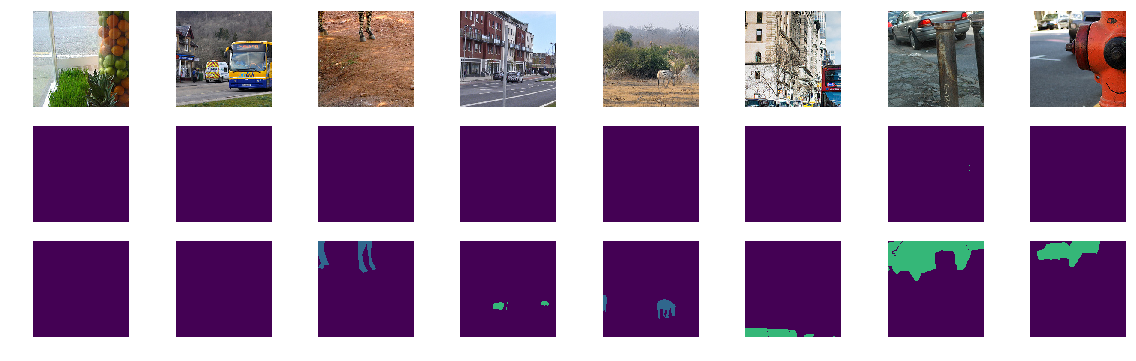

Loss on epoch 1 was: 1.51734662
Test accuracy after epoch 1 was: 0.88543316 +/- 0.22058448
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 6
testing results


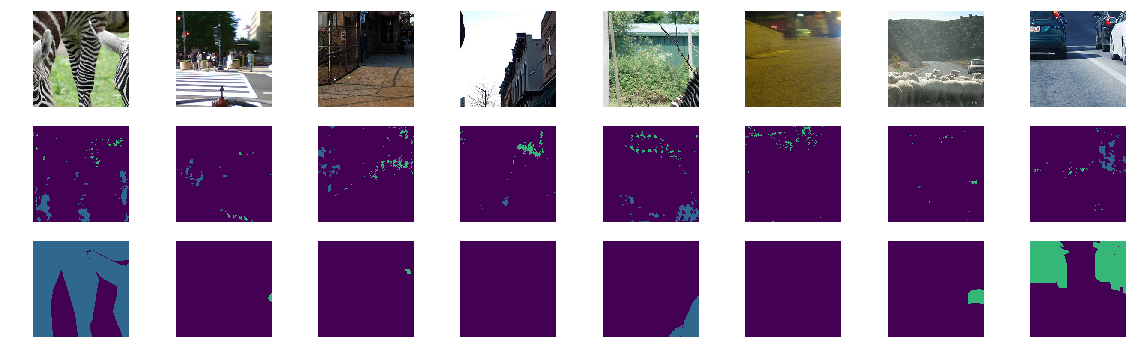

Loss on epoch 6 was: 0.35519499
Test accuracy after epoch 6 was: 0.88809915 +/- 0.18493164
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 7
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 8
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 9
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 10
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 11
testing results


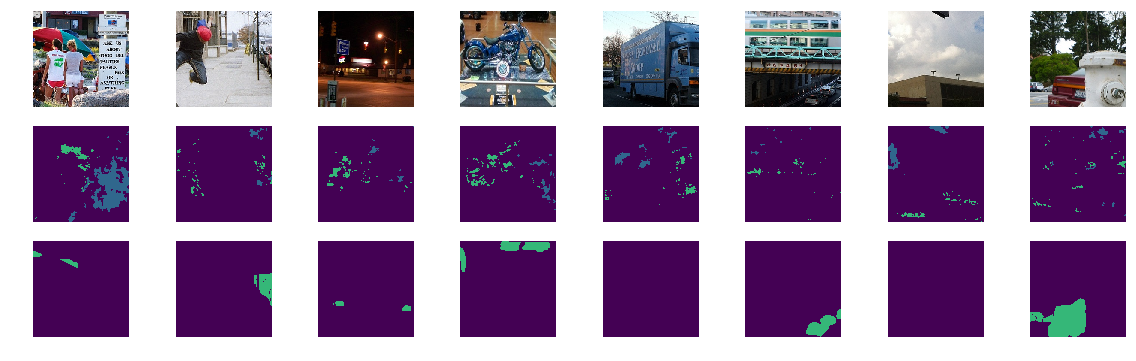

Loss on epoch 11 was: 0.40044913
Test accuracy after epoch 11 was: 0.86049644 +/- 0.14833992
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 12
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 13
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 14


Process Process-18:
Traceback (most recent call last):
  File "/home/jeff/anaconda2/envs/pytorch_2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/jeff/anaconda2/envs/pytorch_2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jeff/anaconda2/envs/pytorch_2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/jeff/anaconda2/envs/pytorch_2/lib/python2.7/multiprocessing/queues.py", line 131, in get
    if not self._poll(timeout):
KeyboardInterrupt


KeyboardInterrupt: 

In [11]:
# generate weigth tensor for loss function 
device = 'cuda'
weight_tensor = torch.ones(len(my_segnet.object_label_dict)).to(device)
for key,value in my_segnet.object_label_dict.items():
    weight_tensor[value] = weight_dict[key]   

my_segnet.define_loss_function(loss_fun = nn.CrossEntropyLoss,
                               weight = weight_tensor)

my_segnet.train(num_epochs = 531, 
                save_checkpoint_path = '/home/jeff/Documents/checkpoints/SegNet_COCO/checkpoint.pth',
                final_model_path = '/home/jeff/Documents/checkpoints/SegNet_COCO/zebras_car_final_model.pth',
                resume = False)